See go/flax-air

### Flax

You probably want to keep the Flax documentation ready in another tab:

https://flax.readthedocs.io/

In [ ]:
# from typing import Callable, Sequence  # used ?

import flax
from flax import linen as nn

#### Functional core

In [ ]:
# Simple module with matmul layer. Note that we could build this in many
# different ways using the `scope` for parameter handling.


class Matmul:
    def __init__(self, features):
        self.features = features

    def kernel_init(self, key, shape):
        return jax.random.normal(key, shape)

    def __call__(self, scope, x):
        kernel = scope.param(
            "kernel", self.kernel_init, (x.shape[1], self.features)
        )
        return x @ kernel


class Model:
    def __init__(self, features):
        self.matmuls = [Matmul(f) for f in features]

    def __call__(self, scope, x):
        x = x.reshape([len(x), -1])
        for i, matmul in enumerate(self.matmuls):
            x = scope.child(matmul, f"matmul_{i + 1}")(x)
            if i < len(self.matmuls) - 1:
                x = jax.nn.relu(x)
        x = jax.nn.log_softmax(x)
        return x


model = Model([ds_info.features["label"].num_classes])
y, variables = flax.core.init(model)(key, train_images[:1])
assert (y == flax.core.apply(model)(variables, train_images[:1])).all()

# YOUR ACTION REQUIRED:
# Check out the parameter structure, try adding/removing "layers" and see how it
# changes
##-snip
model = Model([50, ds_info.features["label"].num_classes])
_, variables = flax.core.init(model)(key, train_images[:1])
jax.tree_map(jnp.shape, variables)

FrozenDict({
    params: {
        matmul_1: {
            kernel: (784, 50),
        },
        matmul_2: {
            kernel: (50, 10),
        },
    },
})

final loss: 0.7789248


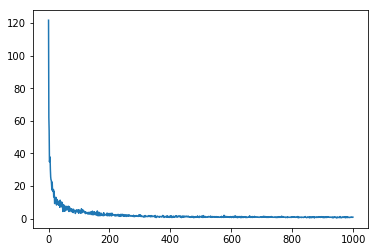

In [ ]:
# YOUR ACTION REQUIRED:
# Redefine loss_fun(), update_step(), and train() from above to train the new
# model.
##-snip


@jax.jit
def update_step(variables, inputs, targets):
    def loss_fun(variables):
        logits = flax.core.apply(model)(variables, inputs)
        logprobs = logits - jax.scipy.special.logsumexp(
            logits, axis=-1, keepdims=True
        )
        return -logprobs[jnp.arange(len(targets)), targets].mean()

    loss, grads = jax.value_and_grad(loss_fun)(variables)
    updated_variables = jax.tree_multimap(
        lambda variable, grad: variable - 0.05 * grad, variables, grads
    )
    return updated_variables, loss


def train(variables, steps, batch_size=128):
    losses = []
    steps_per_epoch = len(train_images) // batch_size
    for step in range(steps):
        i0 = (step % steps_per_epoch) * batch_size
        variables, loss = update_step(
            variables,
            train_images[i0 : i0 + batch_size],
            train_labels[i0 : i0 + batch_size],
        )
        losses.append(float(loss))
    return variables, jnp.array(losses)


learnt_variables, losses = train(variables, steps=1_000)

plt.plot(losses)
print("final loss:", np.mean(losses[-100]))

#### Stateless Linen module

In [ ]:
# Reimplementation of above model using the Linen API.


class Model(nn.Module):
    num_classes: int

    def setup(self):
        self.dense = nn.Dense(self.num_classes)

    def __call__(self, x):
        x = x.reshape([len(x), -1])
        x = self.dense(x)
        x = nn.log_softmax(x)
        return x


model = Model(num_classes=ds_info.features["label"].num_classes)
variables = model.init(jax.random.PRNGKey(0), train_images[:1])
jax.tree_map(jnp.shape, variables)

FrozenDict({
    params: {
        dense: {
            bias: (10,),
            kernel: (784, 10),
        },
    },
})

In [ ]:
# YOUR ACTION REQUIRED:
# 1. Rewrite above model using the @nn.compact notation.
# 2. Extend the model to use additional layers, see e.g.
#    convolutions in
#    http://google3/third_party/py/flax/linen/linear.py
##-snip


class Model(nn.Module):
    num_classes: int

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        x = nn.log_softmax(x)
        return x

In [ ]:
model = Model(ds_info.features["label"].num_classes)
variables = model.init(key, train_images[:1])
jax.tree_map(jnp.shape, variables)

FrozenDict({
    params: {
        Conv_0: {
            bias: (32,),
            kernel: (3, 3, 1, 32),
        },
        Conv_1: {
            bias: (64,),
            kernel: (3, 3, 32, 64),
        },
        Dense_0: {
            bias: (256,),
            kernel: (3136, 256),
        },
        Dense_1: {
            bias: (10,),
            kernel: (256, 10),
        },
    },
})

final loss: 0.24742776


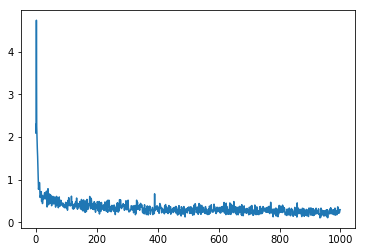

In [ ]:
# Reimplementation of training loop using a Flax optimizer.


@jax.jit
def update_step_optim(optim, inputs, targets):
    def loss_fun(params):
        logits = model.apply(dict(params=params), inputs)
        logprobs = logits - jax.scipy.special.logsumexp(
            logits, axis=-1, keepdims=True
        )
        return -logprobs[jnp.arange(len(targets)), targets].mean()

    loss, grads = jax.value_and_grad(loss_fun)(optim.target)
    return optim.apply_gradient(grads), loss


def train_optim(optim, steps, batch_size=128):
    losses = []
    steps_per_epoch = len(train_images) // batch_size
    for step in range(steps):
        i0 = (step % steps_per_epoch) * batch_size
        optim, loss = update_step_optim(
            optim,
            train_images[i0 : i0 + batch_size],
            train_labels[i0 : i0 + batch_size],
        )
        losses.append(float(loss))
    return optim, jnp.array(losses)


optim = flax.optim.adam.Adam(learning_rate=0.01).create(variables["params"])
learnt_optim, losses = train_optim(optim, steps=1_000)
plt.plot(losses)
print("final loss:", np.mean(losses[-100]))

In [ ]:
# Re-evaluate accuracy.
(
    model.apply(dict(params=learnt_optim.target), test_images).argmax(axis=-1)
    == test_labels
).mean()

DeviceArray(0.88199997, dtype=float32)

#### Linen module with state

In [ ]:
# Let's add batch norm!
# I'm not saying it's a good idea here, but it will allow us study the changes
# we need to make for models that have state.


class Model(nn.Module):
    num_classes: int

    @nn.compact
    def __call__(self, x, *, train):
        x = x.reshape([len(x), -1])
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.Dense(self.num_classes)(x)
        x = nn.log_softmax(x)
        return x


model = Model(num_classes=ds_info.features["label"].num_classes)
variables = model.init(jax.random.PRNGKey(0), train_images[:1], train=True)
jax.tree_map(jnp.shape, variables)

# Note the new "batch_stats" collection !

FrozenDict({
    batch_stats: {
        BatchNorm_0: {
            mean: (784,),
            var: (784,),
        },
    },
    params: {
        BatchNorm_0: {
            bias: (784,),
            scale: (784,),
        },
        Dense_0: {
            bias: (10,),
            kernel: (784, 10),
        },
    },
})

final loss: 0.37923503


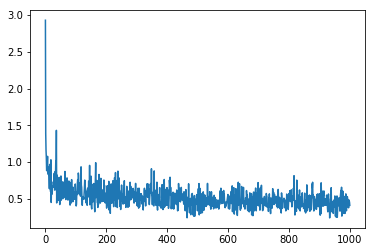

In [ ]:
# YOUR ACTION REQUIRED:
# Check below code and add comments for every change compared to the model above
# without state.


@jax.jit
def update_step_optim(optim, batch_stats, inputs, targets):
    def loss_fun(params):
        logits, mutated_state = model.apply(
            dict(params=params, batch_stats=batch_stats),
            inputs,
            mutable="batch_stats",
            train=True,
        )
        logprobs = logits - jax.scipy.special.logsumexp(
            logits, axis=-1, keepdims=True
        )
        return (
            -logprobs[jnp.arange(len(targets)), targets].mean(),
            variables["batch_stats"],
        )

    (loss, state), grads = jax.value_and_grad(loss_fun, has_aux=True)(
        optim.target
    )
    return optim.apply_gradient(grads), batch_stats, loss


def train_optim(optim, batch_stats, steps, batch_size=128):
    losses = []
    steps_per_epoch = len(train_images) // batch_size
    for step in range(steps):
        i0 = (step % steps_per_epoch) * batch_size
        optim, batch_stats, loss = update_step_optim(
            optim,
            batch_stats,
            train_images[i0 : i0 + batch_size],
            train_labels[i0 : i0 + batch_size],
        )
        losses.append(float(loss))
    return optim, batch_stats, jnp.array(losses)


optim = flax.optim.adam.Adam(learning_rate=0.01).create(variables["params"])
learnt_optim, batch_stats, losses = train_optim(
    optim, variables["batch_stats"], steps=1_000
)
plt.plot(losses)
print("final loss:", np.mean(losses[-100]))

In [ ]:
# YOUR ACTION REQUIRED:
# Make predictions with above model with state
##-snip
(
    model.apply(
        dict(params=learnt_optim.target, batch_stats=batch_stats),
        test_images,
        train=False,
    ).argmax(axis=-1)
    == test_labels
).mean()

DeviceArray(0.4622, dtype=float32)

#### Modify MNIST example

Check out the Flax MNIST example Colab - you can find a link on Github

https://github.com/google/flax/tree/master/linen_examples/mnist

In [ ]:
# YOUR ACTION REQURIED:
# Store the Colab in your personal drive and modify it to use the dataset from
# above.
# While this might sound boring, you will learn the following things:
# - how to load files in public Colab from Github, modify them in the UI and
#   optionally store them on your personal Google Drive.
# - how to use inline TensorBoard on public Colab and export it to tensorboard.dev

### end